# Báo cáo cuối kỳ Thị Giác Máy Tính


## I. Giới thiệu đề tài
Trong thời đại chuyển đổi số hiện nay, việc số hóa thông tin từ các tài liệu giấy tờ như căn cước công dân (CCCD) là một nhu cầu thiết yếu, phục vụ cho các hệ thống tự động hóa quản lý, định danh và lưu trữ dữ liệu. Tuy nhiên, các tài liệu này thường được chụp dưới nhiều điều kiện khác nhau (nghiêng, mờ, ánh sáng yếu...), dẫn đến việc xử lý tự động gặp nhiều thách thức.
1. Xác định 4 góc của căn cước công dân trong ảnh để xử lý ảnh.
2. Xác định vùng chứa chữ để trích xuất các trường dữ liệu của ảnh.
3. Nhận dạng ký tự trong từng vùng, nhằm số hóa nội dung.

Hệ thống được triển khai bằng mô hình YOLOv8 để xử lý các bước phát hiện góc và vùng chữ, kết hợp với Tesseract OCR cho bước nhận dạng ký tự. Đề tài cũng được tích hợp vào một hệ thống web demo gồm frontend Vue.js và backend FastAPI để thể hiện khả năng ứng dụng thực tiễn.

In [17]:
%matplotlib inline

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## II. Giới thiệu về tập dữ liệu
Hình ảnh Căn Cước Công Dân được thu thập từ các nguồn như Roboflow, Kaggle, Internet và tự chụp

In [130]:
import yaml
import os

def describe_yolov8_dataset(data_yaml_path, dataset_title):
    def count_files(folder, ext):
        if not os.path.exists(folder):
            return 0
        return len([f for f in os.listdir(os.path.join(folder, 'images')) if f.lower().endswith(ext)])

    with open(data_yaml_path, "r") as f:
        data = yaml.safe_load(f)

    root_path = os.path.dirname(data_yaml_path)

    train_path = os.path.join(root_path, 'train')
    val_path = os.path.join(root_path, 'valid')
    test_path = os.path.join(root_path, 'test')

    train_images = count_files(train_path, ('.jpg', '.jpeg', '.png'))
    val_images = count_files(val_path, ('.jpg', '.jpeg', '.png'))
    test_images = count_files(test_path, ('.jpg', '.jpeg', '.png')) if os.path.exists(test_path) else 0

    print(f"Mô tả tập dữ liệu {dataset_title}")
    print(f"Đường dẫn: {root_path}")
    print(f"- Số lớp: {data['nc']} | {data['names']}")
    print(f"- Số ảnh tập train: {train_images} ảnh")
    print(f"- Số ảnh tập val: {val_images} ảnh")
    if os.path.exists(test_path):
        print(f"- Số ảnh tập test: {test_images} ảnh,")



### 1. Tập dữ liệu để xác định 4 góc của căn
Tập dữ liệu này được tải lên roboflow để gán nhãn. Mỗi ảnh có annotations gồm:
<ul>
    <li>top-left</li>
    <li>top-right</li>
    <li>bottom-left</li>
    <li>bottom-right</li>
</ul>

Link dữ liệu đã gán nhán: <a href="https://app.roboflow.com/socialv2/cornerdetection-vsjvm/models">https://app.roboflow.com/socialv2/cornerdetection-vsjvm/models</a>

In [131]:
CORNER_DATA_PATH = './corner_dataset/data.yaml'
describe_yolov8_dataset(CORNER_DATA_PATH, 'corder_dataset')

Mô tả tập dữ liệu corder_dataset
Đường dẫn: ./corner_dataset
- Số lớp: 4 | ['bottom-left', 'bottom-right', 'top-left', 'top-right']
- Số ảnh tập train: 370 ảnh
- Số ảnh tập val: 105 ảnh
- Số ảnh tập test: 53 ảnh,


### 2. Tập dữ liệu để xác định (Mặt trước)
Tập dữ liệu này cũng được tải lên roboflow để gán nhãn. Mỗi ảnh có annotations gồm:
<ul>
    <li>id</li>
    <li>full_name</li>
    <li>date_of_birth</li>
    <li>sex</li>
    <li>nationality</li>
    <li>place_of_origin</li>
    <li>place_of_residence</li>
    <li>date_of_expiry</li>
    <li>qr_code</li>
</ul>

In [133]:
FRONT_FIELD_DATA_PATH = './front_cccd_dataset/front-field-data.yaml'
describe_yolov8_dataset(FRONT_FIELD_DATA_PATH, 'front-cccd-dataset')

Mô tả tập dữ liệu front-cccd-dataset
Đường dẫn: ./front_cccd_dataset
- Số lớp: 9 | ['id', 'full_name', 'date_of_birth', 'sex', 'nationality', 'place_of_origin', 'place_of_residence', 'date_of_expiry', 'qr_code']
- Số ảnh tập train: 1693 ảnh
- Số ảnh tập val: 172 ảnh
- Số ảnh tập test: 59 ảnh,


### 3. Tập dữ liệu để xác định (Mặt sau)
Tập dữ liệu này cũng được tải lên roboflow để gán nhãn. Mỗi ảnh có annotations gồm:
<ul>
    <li>fingerprint</li>
    <li>issue_date</li>
    <li>issue_place</li>
    <li>personal_identification</li>
</ul>
Link dữ liệu đã gán nhán: <a href="https://app.roboflow.com/socialv2/backcccd/7">https://app.roboflow.com/socialv2/backcccd/7</a>

In [134]:
BACK_FIELD_DATA_PATH = './back_cccd_dataset/data.yaml'
describe_yolov8_dataset(BACK_FIELD_DATA_PATH, 'back-cccd-dataset')

Mô tả tập dữ liệu back-cccd-dataset
Đường dẫn: ./back_cccd_dataset
- Số lớp: 4 | ['fingerprint', 'issue_date', 'issue_place', 'personal_identification']
- Số ảnh tập train: 137 ảnh
- Số ảnh tập val: 33 ảnh


## III. Kỹ thuật tăng cường dữ liệu
Trong quá trình huấn luyện, để cải thiện khả năng tổng quát hóa của mô hình và giảm hiện tượng overfitting, các kỹ thuật sau đây đã được áp dụng trong bài toán.

<ul>
    <li>Điều chỉnh sắc độ (Hue) trong không gian màu HSV để tạo ra màu sắc đa dạng.</li>
    <li>Điều chỉnh độ bão hòa (Saturation), làm ảnh tươi hoặc nhạt hơn.</li>
    <li>Điều chỉnh độ sáng (Brightness) của ảnh.</li>
    <li>Xoay ảnh trong khoảng ±10 độ, giúp mô hình học được các biến dạng do xoay.</li>
    <li>Tịnh tiến ảnh theo cả trục x và y với độ lệch tối đa là 10%</li>
    <li>Phóng to hoặc thu nhỏ ảnh lên đến ±50% để mô hình không phụ thuộc vào kích thước đối tượng.</li>
    <li>Biến dạng hình học bằng phép xiên (shear) ảnh ±2 độ.</li>
    <li>Xác suất lật ảnh theo chiều dọc là 50%.</li>
    <li>Xác suất lật ảnh theo chiều ngang là 50% – thường dùng cho ảnh chứa chữ.</li>
    <li>Áp dụng kỹ thuật Mosaic Augmentation – kết hợp 4 ảnh thành 1 để tăng tính đa dạng bối cảnh.</li>
    <li>Áp dụng kỹ thuật MixUp – trộn hai ảnh cùng nhãn với tỷ lệ 20% để làm mượt biên nhãn.</li>
</ul>

In [2]:
augment_params = dict(
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    shear=0.0,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.0,
)

## IV. Mô hình
### 1. Mô hình đề xuất
Mô hình YOLOv8 (You Only Look Once version 8) – một trong những mô hình phát hiện đối tượng (object detection) hiện đại và mạnh mẽ nhất hiện nay, được phát triển bởi Ultralytics.


In [18]:
from abc import ABC
from ultralytics import YOLO
import os
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

class BaseDetector(ABC):
    def __init__(self, model, save_dir):
        self.model = YOLO(model)
        self.save_dir = save_dir
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def train(self, data, epochs, imgsz, batch, patience, freeze, augment_params):
        if not os.path.exists(data):
            raise FileNotFoundError(f"Không tìm thấy file {data}. Hãy kiểm tra đường dẫn!")
        
        if freeze is not None:
            self.freeze_layer(self.model, num_freeze=freeze)

        self.model.train(
            data=data,
            epochs=epochs,
            imgsz=imgsz,
            batch=batch,
            device=self.device,
            patience=patience,
            amp=True,
            augment=True,
            project=self.save_dir,
            **augment_params
        )

    def predict(self, img):
        return self.model(img, verbose=False)

    def freeze_layer(self, trainer, num_freeze):
        model = trainer.model
        freeze = [f'model.{x}.' for x in range(num_freeze)]
        for k, v in model.named_parameters():
            v.requires_grad = True
            if any(x in k for x in freeze):
                v.requires_grad = False
        print(f"✅ {num_freeze} layers frozen successfully.")

    def evaluate(self, data):
        metrics = self.model.val(data=data, project=self.save_dir )
        return {
            "mean_mAP50": np.mean(metrics.box.map50),
            "mean_mAP50-95": np.mean(metrics.box.map),
            "mean_precision": np.mean(metrics.box.mp),
            "mean_recall": np.mean(metrics.box.mr)
        }

    def plot_loss_history(self):
        data = pd.read_csv(os.path.join(self.save_dir, 'train/results.csv'))
        plt.figure(figsize=(14, 8))

        # Box Loss
        plt.subplot(2, 2, 1)
        plt.plot(data['epoch'], data['train/box_loss'], label='Train Box Loss')
        plt.plot(data['epoch'], data['val/box_loss'], label='Val Box Loss')
        plt.title('Box Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Classification Loss
        plt.subplot(2, 2, 2)
        plt.plot(data['epoch'], data['train/cls_loss'], label='Train Cls Loss')
        plt.plot(data['epoch'], data['val/cls_loss'], label='Val Cls Loss')
        plt.title('Classification Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # DFL Loss
        plt.subplot(2, 2, 3)
        plt.plot(data['epoch'], data['train/dfl_loss'], label='Train DFL Loss')
        plt.plot(data['epoch'], data['val/dfl_loss'], label='Val DFL Loss')
        plt.title('DFL Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Combined Total Loss (Train and Val)
        plt.subplot(2, 2, 4)
        plt.plot(data['epoch'], data['train/box_loss'] + data['train/cls_loss'] + data['train/dfl_loss'], label='Train Total Loss')
        plt.plot(data['epoch'], data['val/box_loss'] + data['val/cls_loss'] + data['val/dfl_loss'], label='Val Total Loss')
        plt.title('Total Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_val_results(self, data, normalize=True, figsize=(16, 12), max_images=6):
        image_paths = glob.glob(os.path.join(self.save_dir,'val', "*.png"))
        print(image_paths)
        image_paths = sorted(image_paths)[:max_images]

        if not image_paths:
            print("No result images found in validation output directory.")
            return

        n_images = len(image_paths)
        cols = 3
        rows = (n_images + cols - 1) // cols

        fig, axs = plt.subplots(rows, cols, figsize=figsize)
        axs = axs.flatten()

        for i, image_path in enumerate(image_paths):
            img = Image.open(image_path)
            axs[i].imshow(img)
            axs[i].set_title(os.path.basename(image_path))
            axs[i].axis("off")

        for j in range(i + 1, len(axs)):
            axs[j].axis("off")

        plt.tight_layout()
        plt.show()

    def save(self, out="best_model.pt"):
            self.model.save(out)

    def get_model(self):
        return self.model
    
    def print_summary(self):
        print(self.model)
        self.model.info()

### 2. Mô hình phát hiện góc của CCCD
#### 2.1 CorderDetector (sử dụng yolov8n.pt)

In [19]:
class CornerDetector(BaseDetector):
    def __init__(self, model="yolov8n.pt"):
        super().__init__(model=model, save_dir='corner-project-runs')

In [50]:
corner_detector = CornerDetector()

#### 2.2 Trực quan model
- 129 lớp
- 3,157,200 tham số

In [21]:
corner_detector.print_summary()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

### 3. Mô hình phát hiện vùng văn bản mặt trước CCCD
#### 3.1 FrontFieldDetector (sử dụng yolov8l.pt)

In [20]:
class FrontFieldDetector(BaseDetector):
    def __init__(self, model="yolov8l.pt"):
        super().__init__(model=model, save_dir='front-field-project-runs')

In [53]:
front_field_detector = FrontFieldDetector()

#### 3.2 Trực quan model
- 209 lớp
- 43,691,520 tham số

In [24]:
front_field_detector.print_summary()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_r

### 4. Mô hình phát hiện vùng văn bản mặt sau CCCD
#### 4.1 BackFieldDetector (sử dụng yolov8n.pt)

In [21]:
class BackFieldDetector(BaseDetector):
    def __init__(self, model="yolov8n.pt"):
        super().__init__(model=model, save_dir='back-field-project-runs')

In [56]:
back_field_detector = BackFieldDetector()

#### 4.2 Trực quan model

In [57]:
back_field_detector.print_summary()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

## V. Huấn luyện mô hình


### 2. Tham số huấn luyện
- <strong>Thiết bị GPU</strong>: cuda
- <strong>Số epochs</strong>: 100
- <strong>Kích thước batch</strong>: 16
- <strong>Kích thước đầu vào</strong>: (640x640)

In [37]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 30
BATCH_SIZE = 16
IMG_SIZE = 640

print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU name: NVIDIA GeForce RTX 3060


### 3. Quá trình huấn luyện

#### 3.1. Huấn luyện mô hình phát hiện góc

In [41]:
CORNER_DATA_PATH = 'corner_dataset/data.yaml'
SAVED_CORNER_MODEL = "corner_model_final.pt"

training_params = dict(
    data=FRONT_FIELD_DATA_PATH,
    patience=20,
    freeze=20,
    augment_params=augment_params,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    epochs=EPOCHS
)

corner_detector.train(**training_params)
corner_detector.save(SAVED_CORNER_MODEL)

✅ 20 layers frozen successfully.
New https://pypi.org/project/ultralytics/8.3.131 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=front-field-data.yaml, epochs=30, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=corner-project-runs, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=Fal

train: Scanning /home/social-v2/CV_Project/src/modules/fields_recognition/dataset_v2.1_new/train/labels.cache... 1693 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1693/1693 [00:00<?, ?it/s]

albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'



val: Scanning /home/social-v2/CV_Project/src/modules/fields_recognition/dataset_v2.1_new/valid/labels.cache... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<?, ?it/s]


Plotting labels to corner-project-runs/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to corner-project-runs/train2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.85G      1.201      2.458      1.174        202        640: 100%|██████████| 106/106 [00:20<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


                   all        172       1322      0.904        0.8      0.886      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.85G     0.5774     0.7495     0.8812        209        640: 100%|██████████| 106/106 [00:18<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        172       1322      0.911      0.926      0.962      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.85G     0.5364     0.6289     0.8661        229        640: 100%|██████████| 106/106 [00:16<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.91it/s]

                   all        172       1322      0.887      0.948      0.964      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.85G     0.4677     0.5634     0.8509        255        640: 100%|██████████| 106/106 [00:17<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.15it/s]

                   all        172       1322      0.925      0.925      0.959      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.85G     0.4474     0.5265     0.8461        171        640: 100%|██████████| 106/106 [00:16<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.12it/s]

                   all        172       1322      0.935      0.929      0.976      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.85G     0.4247     0.4955     0.8428        177        640: 100%|██████████| 106/106 [00:17<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        172       1322       0.96      0.904      0.976      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.85G     0.4248      0.476     0.8422        208        640: 100%|██████████| 106/106 [00:17<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.28it/s]

                   all        172       1322      0.931      0.919      0.973      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.85G     0.4007     0.4464     0.8371        218        640: 100%|██████████| 106/106 [00:16<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.21it/s]

                   all        172       1322      0.904      0.951      0.973      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.85G     0.3837     0.4277     0.8328        253        640: 100%|██████████| 106/106 [00:16<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.18it/s]

                   all        172       1322      0.956      0.923      0.976      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.85G     0.3811     0.4199     0.8337        212        640: 100%|██████████| 106/106 [00:19<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


                   all        172       1322       0.96      0.931       0.98       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.85G      0.373     0.4091     0.8316        206        640: 100%|██████████| 106/106 [00:18<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

                   all        172       1322      0.969      0.908      0.979      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.85G     0.3649     0.4008     0.8303        214        640: 100%|██████████| 106/106 [00:16<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]

                   all        172       1322      0.918      0.946      0.974      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.85G     0.3567     0.3833     0.8276        182        640: 100%|██████████| 106/106 [00:17<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

                   all        172       1322      0.936      0.928      0.979      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.85G     0.3592     0.3785     0.8308        230        640: 100%|██████████| 106/106 [00:17<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.12it/s]

                   all        172       1322      0.938      0.899      0.976      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.85G      0.351     0.3704     0.8263        185        640: 100%|██████████| 106/106 [00:18<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]

                   all        172       1322      0.943       0.94       0.98       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.85G     0.3446     0.3628     0.8259        194        640: 100%|██████████| 106/106 [00:16<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]

                   all        172       1322      0.961       0.91      0.978      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.85G     0.3364     0.3541     0.8259        160        640: 100%|██████████| 106/106 [00:17<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.15it/s]

                   all        172       1322       0.97      0.915      0.981      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.85G     0.3277     0.3439     0.8225        229        640: 100%|██████████| 106/106 [00:16<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]

                   all        172       1322      0.946      0.886      0.968      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.85G     0.3268     0.3384     0.8233        255        640: 100%|██████████| 106/106 [00:18<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]

                   all        172       1322      0.948      0.917      0.979      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.85G     0.3263     0.3326      0.821        218        640: 100%|██████████| 106/106 [00:16<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]

                   all        172       1322      0.978      0.911      0.982       0.96


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.85G     0.2999     0.3315     0.8068        117        640: 100%|██████████| 106/106 [00:18<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.12it/s]

                   all        172       1322      0.949      0.918      0.978      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.85G     0.2863      0.308     0.8048        115        640: 100%|██████████| 106/106 [00:16<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]

                   all        172       1322      0.941      0.934      0.975      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.85G     0.2834     0.3013     0.8019        108        640: 100%|██████████| 106/106 [00:18<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]

                   all        172       1322      0.944      0.926      0.979      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.86G     0.2735     0.2889     0.8028         97        640: 100%|██████████| 106/106 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]

                   all        172       1322      0.943      0.932      0.981      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.86G     0.2719     0.2862        0.8        115        640: 100%|██████████| 106/106 [00:16<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]

                   all        172       1322      0.932      0.931      0.979      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.86G     0.2645     0.2757     0.7977        110        640: 100%|██████████| 106/106 [00:16<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]

                   all        172       1322      0.942      0.935      0.982      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.86G     0.2637     0.2718     0.7983         96        640: 100%|██████████| 106/106 [00:17<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

                   all        172       1322      0.963       0.93      0.983      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.86G     0.2549     0.2653     0.7951        107        640: 100%|██████████| 106/106 [00:16<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]

                   all        172       1322      0.955      0.929      0.981      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.86G     0.2487     0.2597     0.7951        108        640: 100%|██████████| 106/106 [00:16<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]

                   all        172       1322      0.955      0.934      0.982      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.86G     0.2454     0.2518     0.7926        106        640: 100%|██████████| 106/106 [00:15<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]

                   all        172       1322      0.951      0.936      0.982      0.961



30 epochs completed in 0.163 hours.
Optimizer stripped from corner-project-runs/train2/weights/last.pt, 6.2MB
Optimizer stripped from corner-project-runs/train2/weights/best.pt, 6.2MB

Validating corner-project-runs/train2/weights/best.pt...
Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


                   all        172       1322      0.952      0.938      0.982      0.946
                    id        171        173      0.993      0.983      0.987      0.967
             full_name        164        164      0.949          1      0.991      0.964
         date_of_birth        146        147          1      0.862      0.975      0.941
                   sex        132        132      0.992       0.94      0.991      0.969
           nationality        160        171          1      0.834      0.974      0.941
       place_of_origin        120        143      0.755      0.895      0.954      0.886
    place_of_residence         99        147      0.907      0.939      0.976      0.898
        date_of_expiry        121        121      0.979          1      0.995      0.953
               qr_code        124        124      0.997      0.992      0.995      0.994
Speed: 0.2ms preprocess, 5.7ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to corner-proj

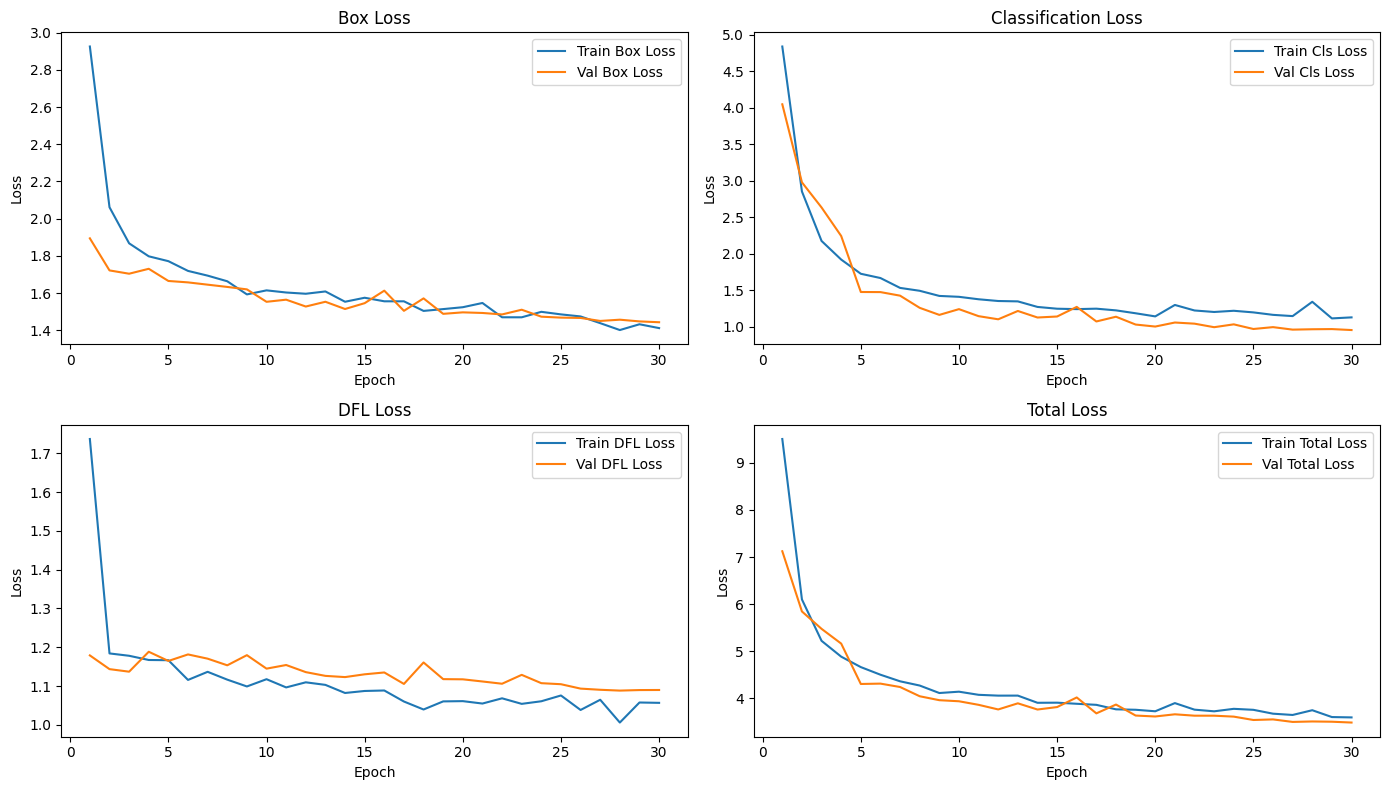

In [51]:
corner_detector.plot_loss_history()

#### 3.2 Huấn luyện mô hình phát hiện vùng văn bản mặt trước CCCD

In [30]:
FRONT_FIELD_DATA_PATH = 'front-field-data.yaml'

training_params = dict(
    data=FRONT_FIELD_DATA_PATH,
    patience=20,
    freeze=20,
    augment_params=augment_params,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    epochs=EPOCHS
)

front_field_detector.train(**training_params)
front_field_detector.save("field_field_model_final.pt")

✅ 20 layers frozen successfully.
New https://pypi.org/project/ultralytics/8.3.131 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=front-field-data.yaml, epochs=30, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=front-field-project-runs, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks

train: Scanning /home/social-v2/CV_Project/src/modules/fields_recognition/dataset_v2.1_new/train/labels.cache... 1693 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1693/1693 [00:00<?, ?it/s]

albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'



val: Scanning /home/social-v2/CV_Project/src/modules/fields_recognition/dataset_v2.1_new/valid/labels.cache... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<?, ?it/s]


Plotting labels to front-field-project-runs/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to front-field-project-runs/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      9.05G     0.9098      1.155      1.103        202        640: 100%|██████████| 106/106 [01:20<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]

                   all        172       1322       0.85      0.898       0.95      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      9.52G     0.5068      0.437      0.888        209        640: 100%|██████████| 106/106 [01:17<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

                   all        172       1322      0.942      0.935      0.976      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      9.75G     0.5119     0.4302      0.883        229        640: 100%|██████████| 106/106 [01:15<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

                   all        172       1322      0.929      0.913      0.965      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      9.54G     0.4435     0.3766     0.8629        255        640: 100%|██████████| 106/106 [01:15<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

                   all        172       1322       0.94      0.913      0.972      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      9.57G     0.4533     0.3669     0.8657        171        640: 100%|██████████| 106/106 [01:13<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

                   all        172       1322      0.954      0.937      0.982       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      9.54G     0.3885      0.328     0.8502        177        640: 100%|██████████| 106/106 [01:14<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]

                   all        172       1322      0.906      0.916      0.974      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      9.59G     0.3946     0.3203      0.851        208        640: 100%|██████████| 106/106 [01:14<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

                   all        172       1322      0.958      0.909      0.981      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      9.54G     0.3695     0.3069     0.8447        218        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all        172       1322      0.938      0.935      0.977      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      9.35G     0.3591     0.2902     0.8418        253        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]

                   all        172       1322      0.927      0.956      0.972       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      9.73G     0.3498     0.2912     0.8416        212        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]

                   all        172       1322      0.931      0.923      0.978      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      9.39G     0.3455     0.2853     0.8373        206        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]

                   all        172       1322      0.935      0.924      0.966      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      9.76G     0.3239     0.2694     0.8328        214        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]

                   all        172       1322       0.95      0.933       0.98      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      9.85G     0.3189      0.265      0.829        182        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all        172       1322      0.941       0.93      0.981      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      9.56G     0.3218     0.2654     0.8327        230        640: 100%|██████████| 106/106 [01:14<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]

                   all        172       1322      0.946      0.949       0.98      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      9.59G     0.3124     0.2563     0.8287        185        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

                   all        172       1322      0.955      0.937      0.983      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       9.5G     0.3009     0.2483     0.8263        194        640: 100%|██████████| 106/106 [01:15<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]

                   all        172       1322      0.938      0.938      0.974      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       9.6G     0.3012     0.2426      0.827        160        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]

                   all        172       1322      0.936      0.909      0.977       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      9.54G     0.2915     0.2398      0.823        229        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all        172       1322      0.942      0.943      0.984      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      9.37G     0.2865     0.2337     0.8212        255        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all        172       1322       0.94       0.95      0.982      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30       9.5G      0.286     0.2275     0.8199        218        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]

                   all        172       1322      0.965       0.93      0.982      0.965


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      9.49G     0.2603     0.2198     0.8031        117        640: 100%|██████████| 106/106 [01:15<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

                   all        172       1322       0.93      0.937      0.976      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      9.42G     0.2567     0.2126     0.7997        115        640: 100%|██████████| 106/106 [01:14<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

                   all        172       1322      0.936      0.934       0.98      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      9.25G     0.2526     0.2113     0.7959        108        640: 100%|██████████| 106/106 [01:14<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

                   all        172       1322      0.928      0.936      0.974      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      9.42G     0.2418     0.1957     0.7972         97        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all        172       1322      0.956      0.952      0.986      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      9.26G     0.2375     0.1914     0.7937        115        640: 100%|██████████| 106/106 [01:14<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

                   all        172       1322      0.931      0.959      0.986       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       9.4G     0.2331     0.1863     0.7926        110        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]

                   all        172       1322      0.939      0.946      0.985      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      9.26G     0.2265     0.1784     0.7908         96        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]

                   all        172       1322      0.947      0.947      0.987      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       9.4G     0.2176     0.1727     0.7854        107        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all        172       1322      0.961      0.938      0.985       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30       9.3G     0.2106      0.163     0.7857        108        640: 100%|██████████| 106/106 [01:14<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.03it/s]

                   all        172       1322      0.955      0.946      0.987      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      9.39G     0.2022      0.154     0.7834        106        640: 100%|██████████| 106/106 [01:15<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all        172       1322      0.954      0.952      0.986      0.975



30 epochs completed in 0.683 hours.
Optimizer stripped from front-field-project-runs/train/weights/last.pt, 87.6MB
Optimizer stripped from front-field-project-runs/train/weights/best.pt, 87.6MB

Validating front-field-project-runs/train/weights/best.pt...
Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
Model summary (fused): 112 layers, 43,613,547 parameters, 0 gradients, 164.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


                   all        172       1322      0.969      0.947      0.987      0.952
                    id        171        173      0.993      0.983      0.994      0.986
             full_name        164        164      0.968      0.994      0.992      0.972
         date_of_birth        146        147      0.983      0.884      0.982      0.935
                   sex        132        132      0.958          1      0.995      0.981
           nationality        160        171      0.968      0.889       0.98      0.948
       place_of_origin        120        143      0.919      0.916      0.969      0.909
    place_of_residence         99        147       0.95      0.871      0.976      0.896
        date_of_expiry        121        121      0.988      0.992      0.995      0.946
               qr_code        124        124      0.998      0.992      0.995      0.994
Speed: 0.2ms preprocess, 25.8ms inference, 0.0ms loss, 8.4ms postprocess per image
Results saved to front-fiel

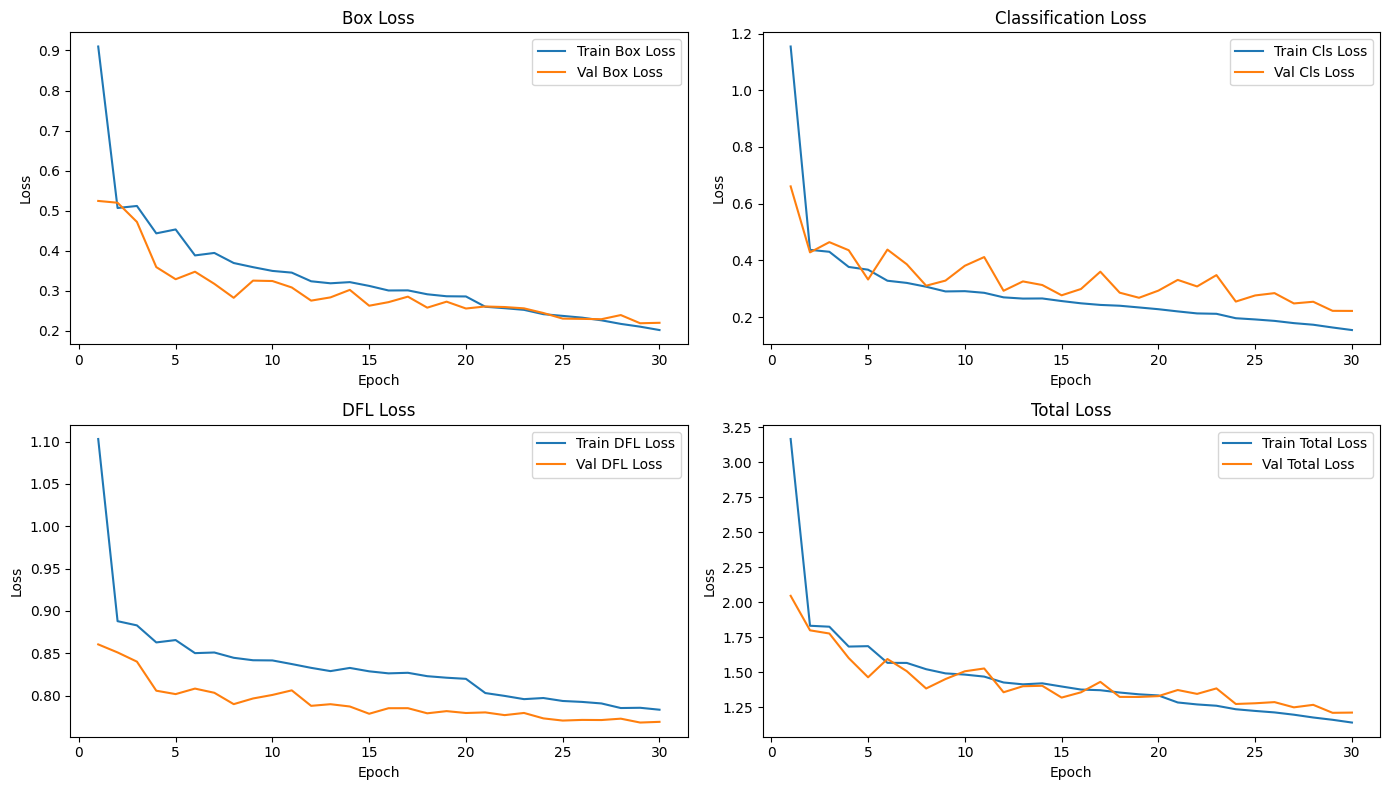

In [54]:
front_field_detector.plot_loss_history()

#### 3.3 Huấn luyện mô hình phát hiện vùng văn bản mặt sau CCCD

In [59]:
BACK_FIELD_DATA_PATH = 'back_cccd_dataset/data.yaml'
SAVED_BACK_FIELD_MODEL = 'back_field_model_final.pt'

training_params = dict(
    data=FRONT_FIELD_DATA_PATH,
    patience=20,
    freeze=20,
    augment_params=augment_params,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    epochs=EPOCHS
)

back_field_detector.train(**training_params)
back_field_detector.save(SAVED_BACK_FIELD_MODEL)

✅ 20 layers frozen successfully.
New https://pypi.org/project/ultralytics/8.3.131 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=front-field-data.yaml, epochs=30, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=back-field-project-runs, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=

train: Scanning /home/social-v2/CV_Project/src/modules/fields_recognition/dataset_v2.1_new/train/labels.cache... 1693 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1693/1693 [00:00<?, ?it/s]

albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'



val: Scanning /home/social-v2/CV_Project/src/modules/fields_recognition/dataset_v2.1_new/valid/labels.cache... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<?, ?it/s]


Plotting labels to back-field-project-runs/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to back-field-project-runs/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      1.201      2.458      1.174        202        640: 100%|██████████| 106/106 [00:20<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        172       1322      0.904        0.8      0.886      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.32G     0.5774     0.7495     0.8812        209        640: 100%|██████████| 106/106 [00:19<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]

                   all        172       1322      0.911      0.926      0.962      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.32G     0.5364     0.6289     0.8661        229        640: 100%|██████████| 106/106 [00:17<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.91it/s]

                   all        172       1322      0.887      0.948      0.964      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.32G     0.4677     0.5634     0.8509        255        640: 100%|██████████| 106/106 [00:16<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.11it/s]

                   all        172       1322      0.925      0.925      0.959      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.32G     0.4474     0.5265     0.8461        171        640: 100%|██████████| 106/106 [00:16<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]

                   all        172       1322      0.935      0.929      0.976      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.32G     0.4247     0.4955     0.8428        177        640: 100%|██████████| 106/106 [00:18<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]

                   all        172       1322       0.96      0.904      0.976      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.32G     0.4248      0.476     0.8422        208        640: 100%|██████████| 106/106 [00:16<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]

                   all        172       1322      0.931      0.919      0.973      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G     0.4007     0.4464     0.8371        218        640: 100%|██████████| 106/106 [00:17<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]

                   all        172       1322      0.904      0.951      0.973      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G     0.3837     0.4277     0.8328        253        640: 100%|██████████| 106/106 [00:17<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.11it/s]

                   all        172       1322      0.956      0.923      0.976      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G     0.3811     0.4199     0.8337        212        640: 100%|██████████| 106/106 [00:18<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]

                   all        172       1322       0.96      0.931       0.98       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      0.373     0.4091     0.8316        206        640: 100%|██████████| 106/106 [00:16<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]

                   all        172       1322      0.969      0.908      0.979      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G     0.3649     0.4008     0.8303        214        640: 100%|██████████| 106/106 [00:16<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]

                   all        172       1322      0.918      0.946      0.974      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G     0.3567     0.3833     0.8276        182        640: 100%|██████████| 106/106 [00:18<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        172       1322      0.936      0.928      0.979      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G     0.3592     0.3785     0.8308        230        640: 100%|██████████| 106/106 [00:19<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

                   all        172       1322      0.938      0.899      0.976      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      0.351     0.3704     0.8263        185        640: 100%|██████████| 106/106 [00:19<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all        172       1322      0.943       0.94       0.98       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G     0.3446     0.3628     0.8259        194        640: 100%|██████████| 106/106 [00:18<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

                   all        172       1322      0.961       0.91      0.978      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G     0.3364     0.3541     0.8259        160        640: 100%|██████████| 106/106 [00:18<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all        172       1322       0.97      0.915      0.981      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.33G     0.3277     0.3439     0.8225        229        640: 100%|██████████| 106/106 [00:18<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all        172       1322      0.946      0.886      0.968      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.33G     0.3268     0.3384     0.8233        255        640: 100%|██████████| 106/106 [00:18<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.50it/s]

                   all        172       1322      0.948      0.917      0.979      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.35G     0.3263     0.3326      0.821        218        640: 100%|██████████| 106/106 [00:19<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.90it/s]

                   all        172       1322      0.978      0.911      0.982       0.96


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.35G     0.2999     0.3315     0.8068        117        640: 100%|██████████| 106/106 [00:19<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.11it/s]

                   all        172       1322      0.949      0.918      0.978      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.35G     0.2863      0.308     0.8048        115        640: 100%|██████████| 106/106 [00:18<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.00it/s]

                   all        172       1322      0.941      0.934      0.975      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.35G     0.2834     0.3013     0.8019        108        640: 100%|██████████| 106/106 [00:18<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]

                   all        172       1322      0.944      0.926      0.979      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.35G     0.2735     0.2889     0.8028         97        640: 100%|██████████| 106/106 [00:18<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.11it/s]

                   all        172       1322      0.943      0.932      0.981      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.35G     0.2719     0.2862        0.8        115        640: 100%|██████████| 106/106 [00:18<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.10it/s]

                   all        172       1322      0.932      0.931      0.979      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.35G     0.2645     0.2757     0.7977        110        640: 100%|██████████| 106/106 [00:18<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]

                   all        172       1322      0.942      0.935      0.982      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.35G     0.2637     0.2718     0.7983         96        640: 100%|██████████| 106/106 [00:18<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.08it/s]

                   all        172       1322      0.963       0.93      0.983      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.35G     0.2549     0.2653     0.7951        107        640: 100%|██████████| 106/106 [00:18<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]

                   all        172       1322      0.955      0.929      0.981      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.35G     0.2487     0.2597     0.7951        108        640: 100%|██████████| 106/106 [00:18<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]

                   all        172       1322      0.955      0.934      0.982      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.35G     0.2454     0.2518     0.7926        106        640: 100%|██████████| 106/106 [00:18<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]

                   all        172       1322      0.951      0.936      0.982      0.961



30 epochs completed in 0.170 hours.
Optimizer stripped from back-field-project-runs/train/weights/last.pt, 6.2MB
Optimizer stripped from back-field-project-runs/train/weights/best.pt, 6.2MB

Validating back-field-project-runs/train/weights/best.pt...
Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


                   all        172       1322      0.952      0.938      0.982      0.946
                    id        171        173      0.993      0.983      0.987      0.967
             full_name        164        164      0.949          1      0.991      0.964
         date_of_birth        146        147          1      0.862      0.975      0.941
                   sex        132        132      0.992       0.94      0.991      0.969
           nationality        160        171          1      0.834      0.974      0.941
       place_of_origin        120        143      0.755      0.895      0.954      0.886
    place_of_residence         99        147      0.907      0.939      0.976      0.898
        date_of_expiry        121        121      0.979          1      0.995      0.953
               qr_code        124        124      0.997      0.992      0.995      0.994
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to back-field-

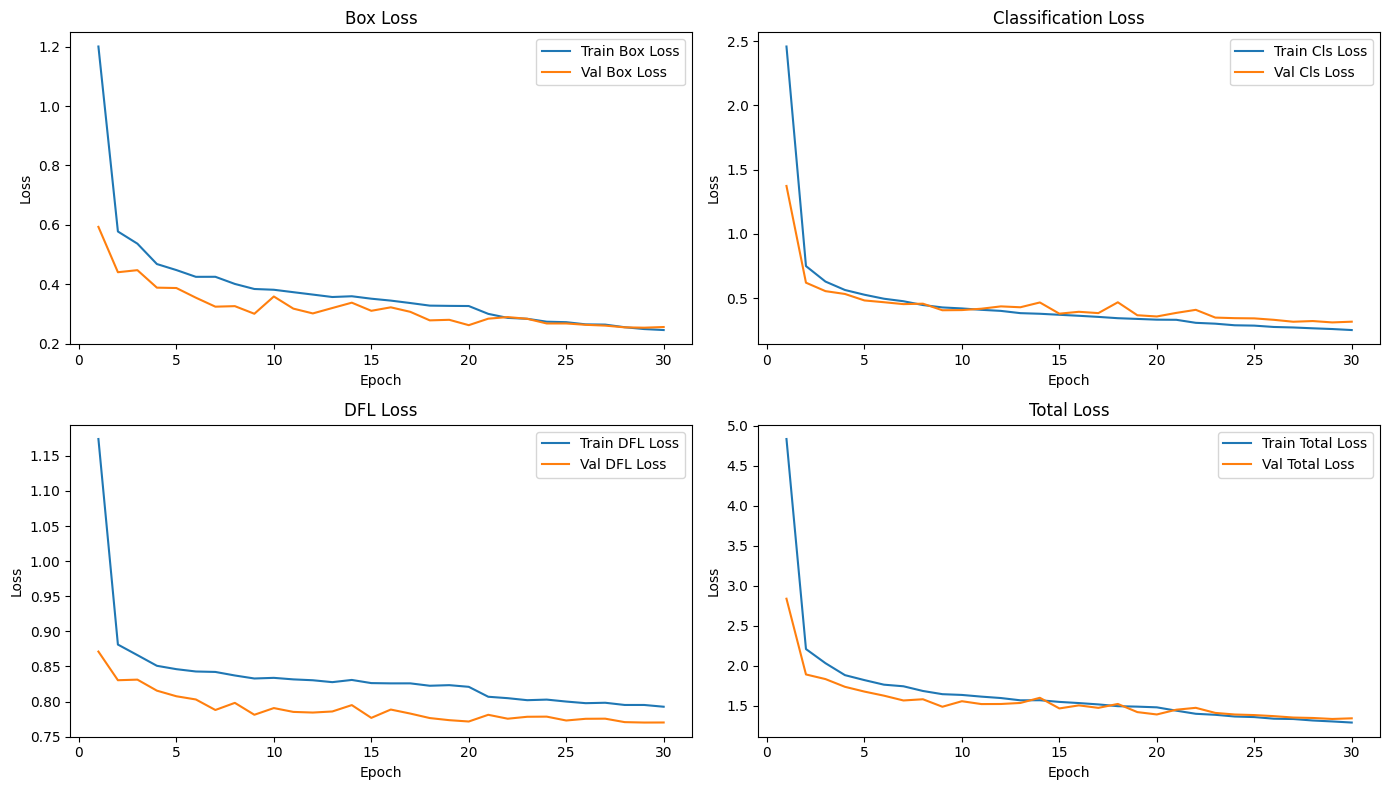

In [60]:
back_field_detector.plot_loss_history()

## VI. Đánh giá mô hình
### 1. Đánh giá dựa trên tập Test
Các chỉ số được dùng để đánh giá:
<ul>
    <li><Strong>Precision</strong>: Tỷ lệ dự đoán đúng trên tổng số dự đoán.</li>
    <li><Strong>Recall</strong>: Tỷ lệ dự đoán đúng trên tổng số thực tế.</li>
    <li><Strong>mAP@0.5 (mean Average Precision)</strong>: Trung bình của Precision ở ngưỡng IoU 0.5.</li>
    <li><Strong>mAP@0.5:0.95</strong>: Trung bình mAP ở nhiều ngưỡng IoU (0.5 đến 0.95 cách 0.05).</li>
</ul>

#### 1.1 Đánh giá mô hình phát hiện góc

In [ ]:
SAVED_CORNER_MODEL = "corner_model_final.pt"
CORNER_DATA_PATH = 'corner_dataset/data.yaml'

corner_detector = CornerDetector(SAVED_CORNER_MODEL)
corner_result = corner_detector.evaluate(CORNER_DATA_PATH)

print(f'\nPrecision: {corner_result["mean_precision"]}')
print(f'Recall: {corner_result["mean_recall"]}')
print(f'mAP@0.5: {corner_result["mean_mAP50"]}')
print(f'mAP@0.5:0.95: {corner_result["mean_mAP50-95"]}')

Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/social-v2/CV_Project/corner_dataset/valid/labels.cache... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


                   all        105        402      0.938      0.915      0.943      0.512
           bottom-left        103        105      0.913      0.905       0.94      0.502
          bottom-right        102        102      0.942      0.948      0.951      0.552
              top-left        103        103       0.95      0.925      0.975      0.511
             top-right         91         92      0.947       0.88      0.907      0.484
Speed: 1.1ms preprocess, 20.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to corner-project-runs/val2

Precision: 0.9381557685612092
Recall: 0.9147660094970135
mAP@0.5: 0.9431175140423452
mAP@0.5:0.95: 0.5124216494440684


#### 1.2 Đánh giá mô hình phát hiện vùng văn bản mặt trước CCCD

In [198]:
SAVED_FRONT_FIELD_MODEL = 'field_field_model_final.pt'
FRONT_FIELD_DATA_PATH = 'front-field-data.yaml'

front_field_detector = FrontFieldDetector(SAVED_FRONT_FIELD_MODEL)
front_field_result = front_field_detector.evaluate(FRONT_FIELD_DATA_PATH)

print(f'\nPrecision: {front_field_result["mean_precision"]}')
print(f'Recall: {front_field_result["mean_recall"]}')
print(f'mAP@0.5: {front_field_result["mean_mAP50"]}')
print(f'mAP@0.5:0.95: {front_field_result["mean_mAP50-95"]}')

Ultralytics 8.3.119  Python-3.11.9 torch-2.8.0.dev20250426+cu126 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


FileNotFoundError: 'front-field-data.yaml' does not exist

#### 1.3 Đánh giá mô hình phát hiện vùng văn bản mặt sau CCCD

In [33]:
SAVED_BACK_FIELD_MODEL = './back_field_model_final.pt'
BACK_FIELD_DATA_PATH = './back_cccd_dataset/data.yaml'

back_field_detector = BackFieldDetector(SAVED_BACK_FIELD_MODEL)
back_field_result = back_field_detector.evaluate(BACK_FIELD_DATA_PATH)

print(f'\nPrecision: {back_field_result["mean_precision"]}')
print(f'Recall: {back_field_result["mean_recall"]}')
print(f'mAP@0.5: {back_field_result["mean_mAP50"]}')
print(f'mAP@0.5:0.95: {back_field_result["mean_mAP50-95"]}')

Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11919MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/social-v2/CV_Project/back_cccd_dataset/valid/labels.cache... 33 images, 0 backgrounds, 0 corrupt: 100%|██████████| 33/33 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


                   all         33        132      0.995          1      0.995      0.822
           fingerprint         33         33      0.992          1      0.995      0.995
            issue_date         33         33      0.998          1      0.995      0.711
           issue_place         33         33      0.995          1      0.995      0.821
personal_identification         33         33      0.996          1      0.995      0.762
Speed: 3.5ms preprocess, 25.4ms inference, 0.0ms loss, 19.4ms postprocess per image
Results saved to back-field-project-runs/val2

Precision: 0.995462481296677
Recall: 1.0
mAP@0.5: 0.995
mAP@0.5:0.95: 0.8221468937868968


### 2. Đánh giá bằng ma trận nhầm lẫn
<ul>
    <li>Sau khi huấn luyện, mô hình được đánh giá thêm bằng quan sát kết quả đầu ra trên nhiều ảnh.</li>
    <li>
        Kiểm tra các trường hợp
        <ul>
            <li>Dự đoán đúng (TP), sai (FP), bỏ sót (FN).</li>
            <li>Mô hình xử lý tốt ảnh mờ, xoay, bị chồng chéo hay không?</li>
        </ul>
    </li>
    <li>Có thể kết hợp với confusion matrix, thống kê lỗi theo từng loại (nếu có phân lớp).</li>
</ul>

#### 2.1 Đánh giá mô hình phát hiện góc

['corner-project-runs/val/PR_curve.png', 'corner-project-runs/val/R_curve.png', 'corner-project-runs/val/P_curve.png', 'corner-project-runs/val/F1_curve.png', 'corner-project-runs/val/confusion_matrix.png', 'corner-project-runs/val/confusion_matrix_normalized.png']


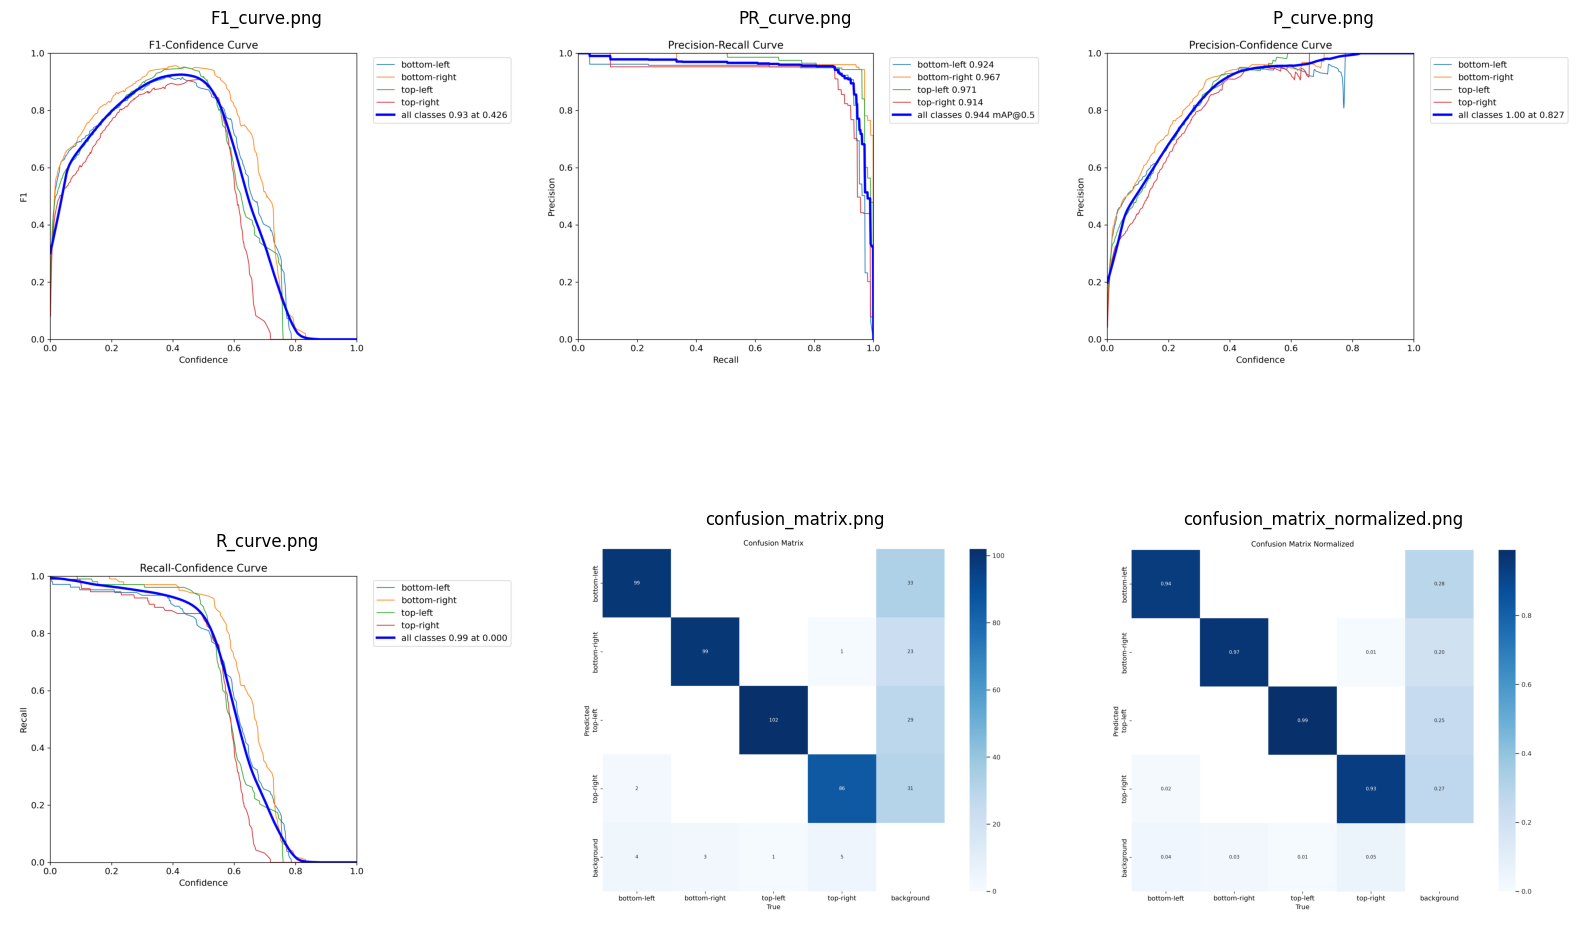

In [42]:
corner_detector.plot_val_results(data=CORNER_DATA_PATH)

#### 2.2 Đánh giá mô hình phát hiện vùng văn bản mặt trước CCCD

['front-field-project-runs/val/PR_curve.png', 'front-field-project-runs/val/R_curve.png', 'front-field-project-runs/val/P_curve.png', 'front-field-project-runs/val/F1_curve.png', 'front-field-project-runs/val/confusion_matrix.png', 'front-field-project-runs/val/confusion_matrix_normalized.png']


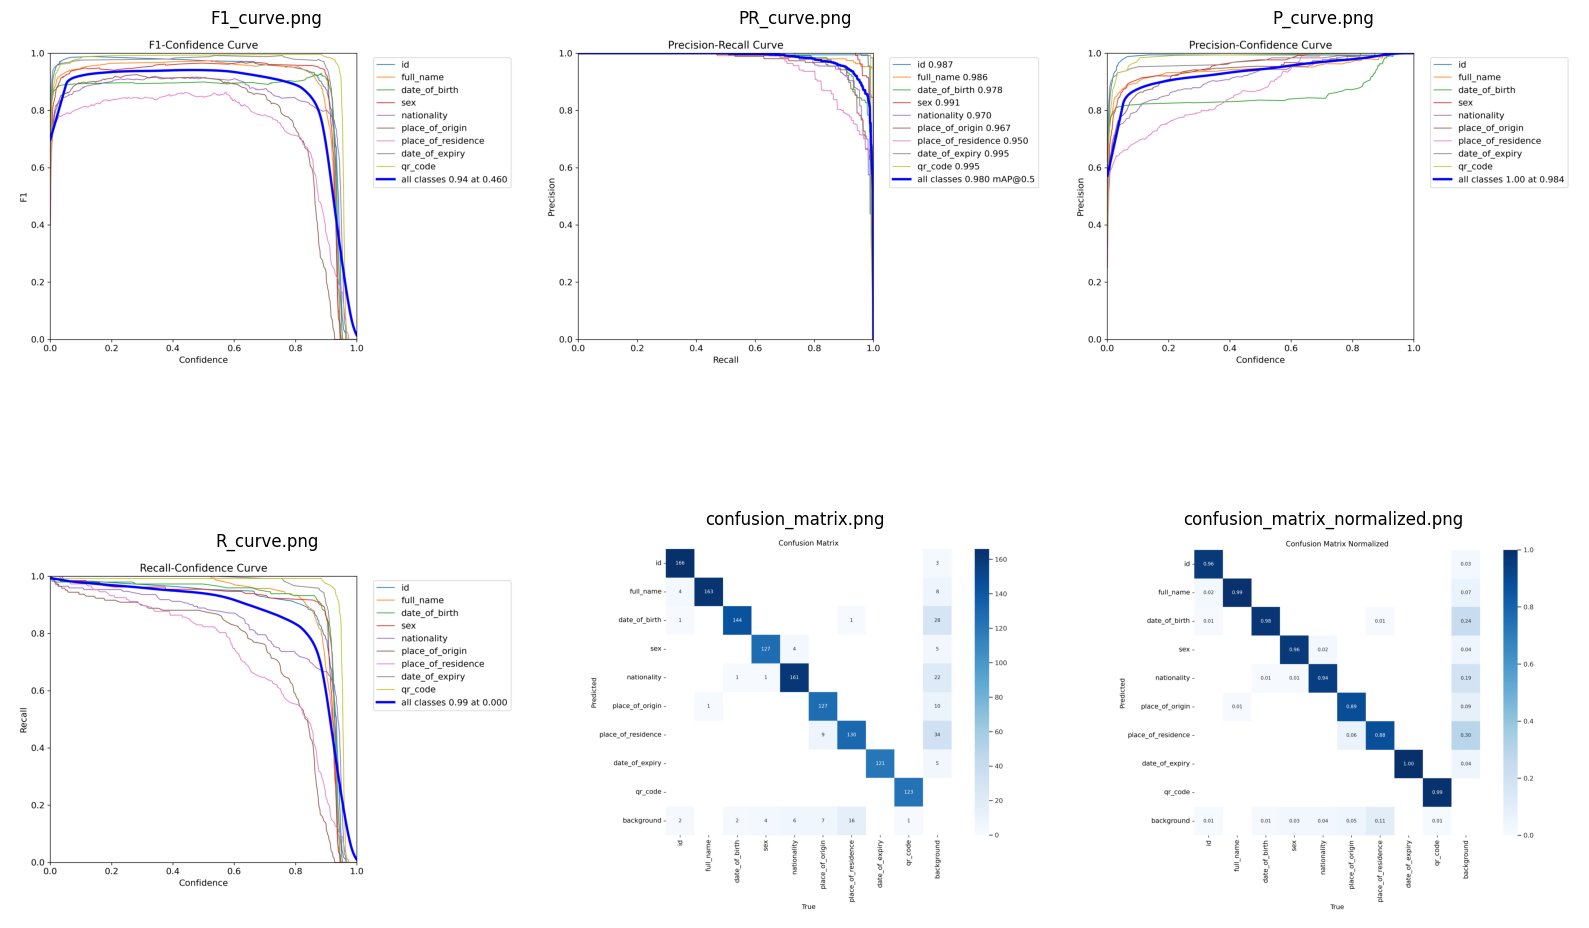

In [235]:
front_field_detector.plot_val_results(data=FRONT_FIELD_DATA_PATH)

#### 2.3 Đánh giá mô hình phát hiện vùng văn bản mặt sau CCCD

['back-field-project-runs/val/PR_curve.png', 'back-field-project-runs/val/R_curve.png', 'back-field-project-runs/val/P_curve.png', 'back-field-project-runs/val/F1_curve.png', 'back-field-project-runs/val/confusion_matrix.png', 'back-field-project-runs/val/confusion_matrix_normalized.png']


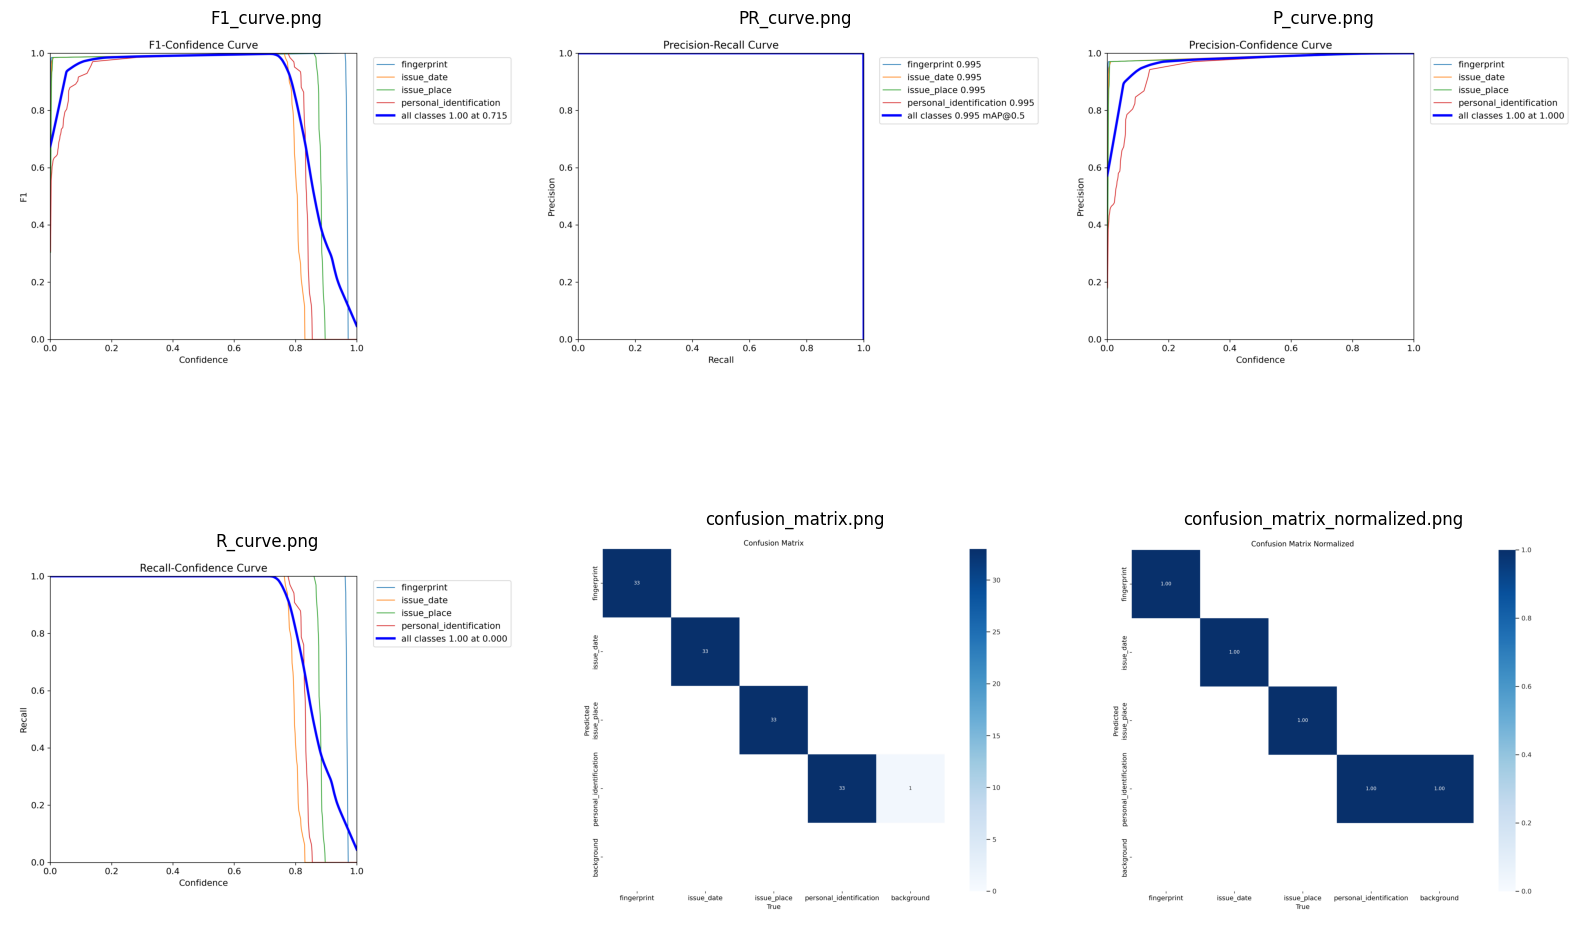

In [244]:
back_field_detector.plot_val_results(BACK_FIELD_DATA_PATH)

### 3. Hiển thị hình ảnh CCCD kèm bounding box


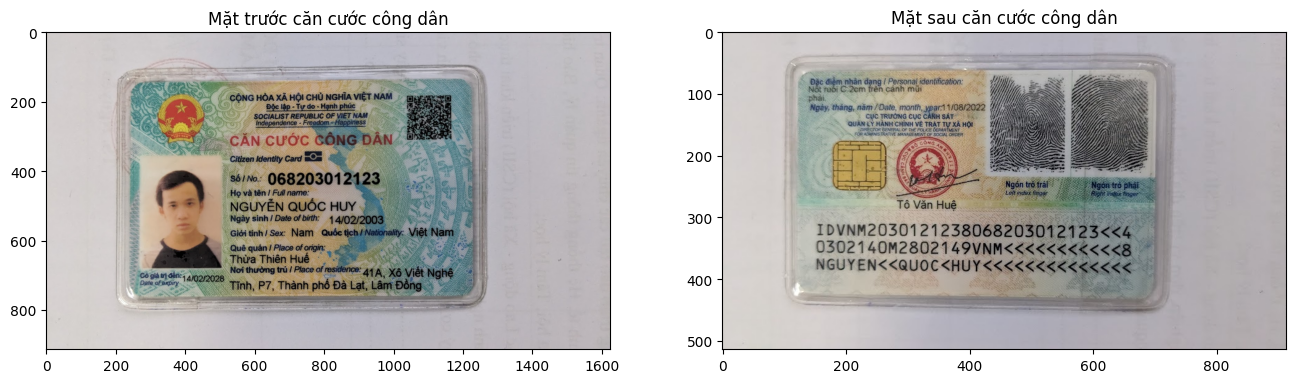

In [141]:
import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np

FRONT_IDCARD_PATH = './mattruoc1.jpg'
BACK_IDCARD_PATH = './matsau1.jpg'

front_img = cv2.imread(FRONT_IDCARD_PATH)
back_img = cv2.imread(BACK_IDCARD_PATH)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(front_img[:, :, ::-1])
plt.title("Mặt trước căn cước công dân")

plt.subplot(1, 2, 2)
plt.imshow(back_img[:, :, ::-1])
plt.title("Mặt sau căn cước công dân")
plt.show()

#### Xử lí kết quả với kỹ thuật NonMaxSuppression

In [143]:
from ultralytics.utils.ops import non_max_suppression

def apply_non_max_suppression(results, conf_thres=0.25, iou_thres=0.45):
    boxes_tensor = results[0].boxes.xyxy
    scores_tensor = results[0].boxes.conf
    class_ids = results[0].boxes.cls

    detections = torch.cat([
        boxes_tensor,
        scores_tensor.unsqueeze(1),
        class_ids.unsqueeze(1)
    ], dim=1)

    nms_result = non_max_suppression(
        detections.unsqueeze(0),
        conf_thres=conf_thres,
        iou_thres=iou_thres
    )[0]
    return nms_result

#### Vẽ bounding-box của các object được phát hiện

In [163]:
def draw_bounding_box(result, img, class_names, nms_result):
    drawed_img = img.copy()
    boxes_tensor = result.boxes.xyxy
    scores_tensor = result.boxes.conf
    class_ids = result.boxes.cls
    detections = torch.cat([
        boxes_tensor,
        scores_tensor.unsqueeze(1),
        class_ids.unsqueeze(1)
    ], dim=1)

    for det in nms_result:
        x1, y1, x2, y2, conf, class_id = det.tolist()
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        class_id = int(class_id)
        label = f"{class_names[class_id]}: {conf:.2f}"

        cv2.rectangle(drawed_img, (x1, y1), (x2, y2), (75, 0, 130), 4)
        (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX, 1.3, 3)
        cv2.rectangle(drawed_img,
                    (x1, y2 + 5),
                    (x1 + text_width, y2 + text_height + 10),
                    (0, 0, 0), -1)
        cv2.putText(drawed_img, label,
            (x1, y2 + text_height + 5),
            cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), thickness=2)
    return drawed_img[:, :, ::-1]



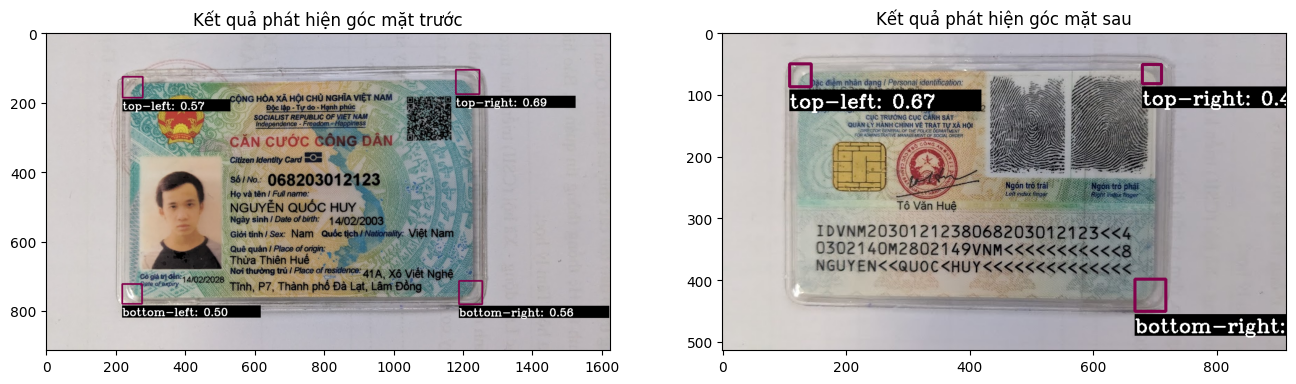

In [179]:
CONF_THRES = 0.4
IOU_THRES = 0.4

corner_classes = corner_detector.get_model().names

# Dự đoán kết quả
front_corner_result = corner_detector.predict(front_img.copy())
back_corner_result = corner_detector.predict(back_img.copy())

# Áp dụng non-max-suppresion
nms_front_idcard = apply_non_max_suppression(front_corner_result, CONF_THRES, IOU_THRES)
nms_back_idcard = apply_non_max_suppression(back_corner_result, CONF_THRES, IOU_THRES)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(draw_bounding_box(front_corner_result[0], front_img.copy(), corner_classes, nms_front_idcard))
plt.title("Kết quả phát hiện góc mặt trước")

plt.subplot(1, 2, 2)
plt.imshow(draw_bounding_box(back_corner_result[0], back_img.copy(), corner_classes, nms_back_idcard))
plt.title("Kết quả phát hiện góc mặt sau")
plt.show()


Ta được kết quả như hai hình trên:
- Mặt trước đầy đủ góc
- Mặt sau thiếu góc (thiếu bottom-left)

#### Xử lí trường hợp nếu thiếu góc:
- Tìm trung điểm bounding-box của góc được phát hiện
- Sử dụng thuật toán nội suy dựa trên các góc được phát hiện với hàm <strong>interpolate_centre_points</strong>

In [188]:
def get_centre_point_boxes(nms_result, classes):
    best_boxes = {}
    centre_points = []
    for box in nms_result:
        x_min, y_min, x_max, y_max, conf, class_id = box.tolist()
        class_name = classes[int(class_id)]
        if class_id not in best_boxes or best_boxes[class_id]['confidence'] < conf:
            x_center = (x_min + x_max) / 2
            y_center = (y_min + y_max) / 2
            best_boxes[class_id] = {
                'confidence': conf
            }
            centre_points.append({
                'x_center': x_center,
                'y_center': y_center,
                'confidence': conf,
                'class_id': class_id,
                'label': f"{class_name}: {conf:.2f}"
            })
    return centre_points


def interpolate_centre_points(centre_points, classes):
    corner_names = {0: "bottom-left", 1: "bottom-right", 2: "top-left", 3: "top-right"}
    opposite_map = {0: 3, 1: 2, 2: 1, 3: 0}
    adjacent_map = {0: [1, 2], 1: [0, 3], 2: [3, 0], 3: [2, 1]}

    id_to_point = {int(p['class_id']): p for p in centre_points}
    known_ids = set(id_to_point.keys())
    all_ids = set(range(len(classes)))
    missing_ids = all_ids - known_ids

    if not missing_ids:
        return centre_points
    
    known_points = list(id_to_point.values())
    avg_x = np.mean([p['x_center'] for p in known_points])
    avg_y = np.mean([p['y_center'] for p in known_points])

    for missing_id in missing_ids:
        interpolated = None

        opp_id = opposite_map[missing_id]
        adj_ids = adjacent_map[missing_id]

        if opp_id in id_to_point and all(a in id_to_point for a in adj_ids):
            opp = id_to_point[opp_id]
            adj1 = id_to_point[adj_ids[0]]
            adj2 = id_to_point[adj_ids[1]]

            x_interp = (adj1['x_center'] + adj2['x_center']) - opp['x_center']
            y_interp = (adj1['y_center'] + adj2['y_center']) - opp['y_center']

            interpolated = {
                'x_center': x_interp,
                'y_center': y_interp,
                'confidence': 0.0,
                'class_id': float(missing_id),
                'label': f"{corner_names[missing_id]} (interpolated)"
            }
        else:
            base = sorted(known_points, key=lambda p: abs(p['class_id'] - missing_id))[0]
            x_interp = 2 * avg_x - base['x_center']
            y_interp = 2 * avg_y - base['y_center']

            interpolated = {
                'x_center': x_interp,
                'y_center': y_interp,
                'confidence': 0.0,
                'class_id': float(missing_id),
                'label': f"{corner_names[missing_id]} (fallback)"
            }

        centre_points.append(interpolated)
    return centre_points

def draw_centre_points(original_img, points):
    cv2_img = original_img.copy()
    cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_RGB2BGR)
    for point in points:
        cv2.circle(cv2_img, (int(point['x_center']), int(point['y_center'])), radius=6, color=(255, 0, 0), thickness=-1)
    return cv2_img[:,:,::-1]

#### 3.1 Kết quả nhận diện góc

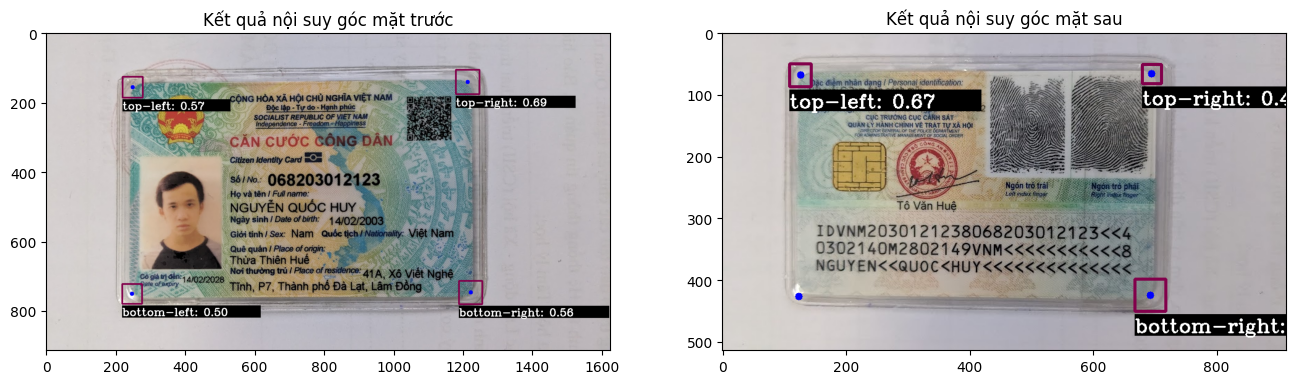

In [192]:
# Áp dụng non-max-suppresion
nms_front_idcard = apply_non_max_suppression(front_corner_result, CONF_THRES, IOU_THRES)
nms_back_idcard = apply_non_max_suppression(back_corner_result, CONF_THRES, IOU_THRES)


front_centre_points = get_centre_point_boxes(nms_front_idcard, corner_classes)
# Áp dụng nội suy interpolate cho mặt trước
front_centre_points = interpolate_centre_points(front_centre_points, corner_classes)
bounding_box_front_img = draw_bounding_box(front_corner_result[0], front_img.copy(), corner_classes, nms_front_idcard)
bounding_box_front_img = draw_centre_points(bounding_box_front_img , front_centre_points)


back_centre_points = get_centre_point_boxes(nms_back_idcard, corner_classes)
# Áp dụng nội suy interpolate cho mặt sau
back_centre_points = interpolate_centre_points(back_centre_points, corner_classes)
bounding_box_back_img = draw_bounding_box(back_corner_result[0], back_img.copy(), corner_classes, nms_back_idcard)
bounding_box_back_img = draw_centre_points(bounding_box_back_img , back_centre_points)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(bounding_box_front_img)
plt.title("Kết quả nội suy góc mặt trước")

plt.subplot(1, 2, 2)
plt.imshow(bounding_box_back_img)
plt.title("Kết quả nội suy góc mặt sau")
plt.show()

Kết quả: ta có thể sử dụng hàm <strong>interpolate_centre_points</strong> để nội suy ra góc bị mất (bottom-left) và đã giải quyết được vấn đề đã đề cập ở trên nhằm đảm bảo đủ 4 góc cho việc xử lý ảnh để nhận diện vùng văn bản một cách chính xác nhất bằng cách sử dụng hàm <strong>warp_image_with_centres</strong>

#### 3.2 Xử lý hình ảnh trước khi nhận diện vùng văn bản trong CCCD
Hàm <strong>warp_image_with_centres</strong> để loại bỏ đi background và xoay ảnh nếu chưa thẳng để nhận diện vùng văn bản chính xác nhất.
- Sắp xếp <strong>centre_pointes</strong> theo thứ tự là:
    - top-left
    - top-right
    - bottom-right
    - bottom-left
- Tính ma trận biến đổi phối cảnh từ 4 điểm góc về khung chuẩn (mặc định là 800x600).
- Áp dụng phép biến đổi để thu được ảnh đã được "dựng thẳng" và sẵn sàng cho bước OCR.

In [194]:
import cv2
import numpy as np
import traceback

def order_points(c_pts):
    sorted_centre_points = sorted(c_pts, key=lambda x: x['class_id'])

    bottom_left = sorted_centre_points[0]
    bottom_right = sorted_centre_points[1]
    top_left = sorted_centre_points[2]
    top_right = sorted_centre_points[3]
    return [top_left, top_right, bottom_right, bottom_left]


def warp_image_with_centres(origin_img, centre_points, output_size=(800, 600)):
    try:
        width, height = output_size
        sorted_centre_points = order_points(centre_points)

        pts = np.array([[pt['x_center'], pt['y_center']] for pt in sorted_centre_points], dtype="float32")
        dst_pts = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype="float32")

        M = cv2.getPerspectiveTransform(pts, dst_pts)
        warped_img = cv2.warpPerspective(origin_img, M, (width, height))
        return warped_img[:,:,::-1]
    except Exception as e:
        print(f"An error occurred: {e}")
        traceback.print_exc()
        return None

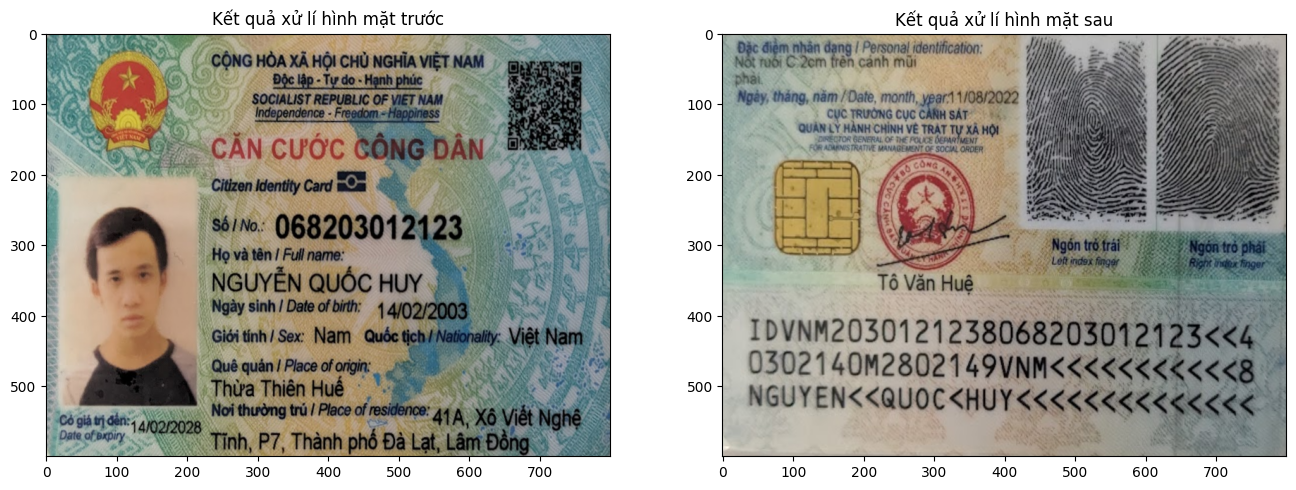

In [195]:
preprocess_front_img = warp_image_with_centres(front_img.copy(), front_centre_points, output_size=(800, 600))
preprocess_back_img = warp_image_with_centres(back_img.copy(), back_centre_points, output_size=(800, 600))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(preprocess_front_img)
plt.title("Kết quả xử lí hình mặt trước")

plt.subplot(1, 2, 2)
plt.imshow(preprocess_back_img)
plt.title("Kết quả xử lí hình mặt sau")
plt.show()

#### 3.3 Kết quả nhận diện vùng văn bản trên CCCD

In [217]:
def draw_bounding_box_fields(result, img, class_names, nms_result):
    drawed_img = img.copy()
    boxes_tensor = result.boxes.xyxy
    scores_tensor = result.boxes.conf
    class_ids = result.boxes.cls
    detections = torch.cat([
        boxes_tensor,
        scores_tensor.unsqueeze(1),
        class_ids.unsqueeze(1)
    ], dim=1)

    for det in nms_result:
        x1, y1, x2, y2, conf, class_id = det.tolist()
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        class_id = int(class_id)
        label = f"{class_names[class_id]}: {conf:.2f}"

        cv2.rectangle(drawed_img, (x1, y1), (x2, y2), (244, 99, 30), 2)
        cv2.putText(drawed_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (244, 99, 30), 2)
    return drawed_img[:, :, ::-1]


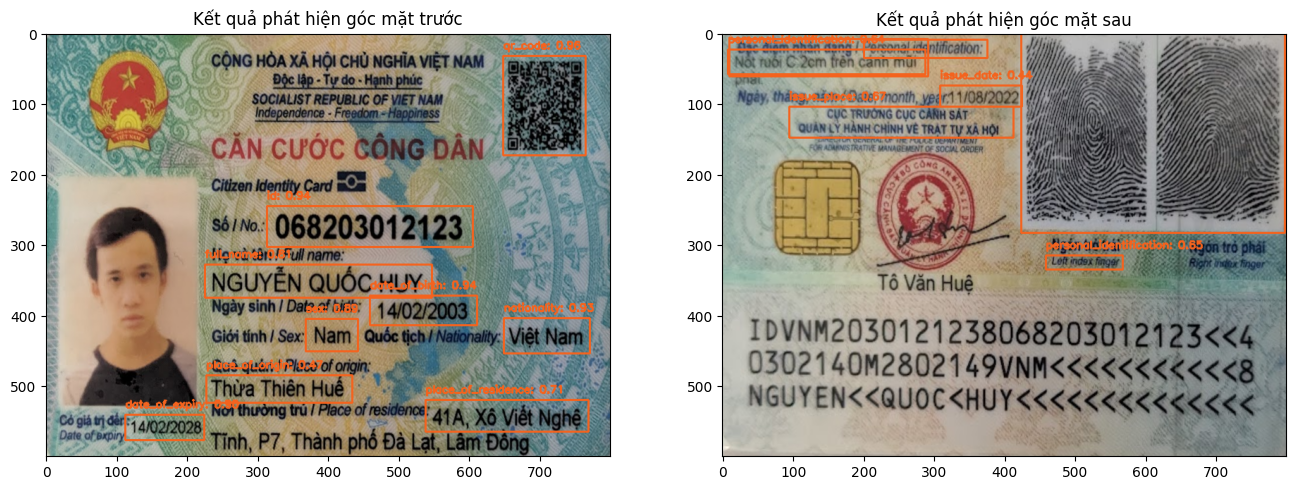

In [223]:
CONF_THRES = 0.4
IOU_THRES = 0.4

front_idcard_classes = front_field_detector.get_model().names
back_idcard_classes = back_field_detector.get_model().names

front_field_results = front_field_detector.predict(preprocess_front_img)
back_field_results = back_field_detector.predict(preprocess_back_img)

# Áp dụng non-max-suppresion
nms_front_field_idcard = apply_non_max_suppression(front_field_results, CONF_THRES, IOU_THRES)
nms_back_field_idcard = apply_non_max_suppression(back_field_results, CONF_THRES, IOU_THRES)

front_field_img_drawed = draw_bounding_box_fields(front_field_results[0], preprocess_front_img.copy(), front_idcard_classes, nms_front_field_idcard)
back_field_img_drawed = draw_bounding_box_fields(back_field_results[0], preprocess_back_img.copy(), back_idcard_classes, nms_back_field_idcard)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(front_field_img_drawed[:,:,::-1])
plt.title("Kết quả phát hiện góc mặt trước")

plt.subplot(1, 2, 2)
plt.imshow(back_field_img_drawed[:,:,::-1])
plt.title("Kết quả phát hiện góc mặt sau")
plt.show()

In [236]:
front_class_names = [
    'id',
    'full_name',
    'date_of_birth',
    'sex',
    'nationality',
    'place_of_origin',
    'place_of_residence',
    'date_of_expiry',
    'qr_code'
]

back_class_names = [
    'fingerprint',
    'issue_date',
    'issue_place',
    'personal_identification'
]

def extract_front_field_images(detector, img):
    results = detector.predict(img)
    pred = results[0]
    
    # Lấy raw boxes
    boxes_tensor = pred.boxes.xyxy
    conf_tensor = pred.boxes.conf
    cls_tensor = pred.boxes.cls

    detections = torch.cat([
        boxes_tensor,
        conf_tensor.unsqueeze(1),
        cls_tensor.unsqueeze(1)
    ], dim=1)

    nms_boxes = non_max_suppression(
        detections.unsqueeze(0), conf_thres=CONF_THRES, iou_thres=IOU_THRES
    )[0]  # chỉ lấy ảnh đầu tiên

    crops = []
    hit_poo = False

    # Sort: class_id → y → x
    sorted_boxes = sorted(nms_boxes, key=lambda box: (int(box[5]), box[1], box[0]))

    for box in sorted_boxes:
        x1, y1, x2, y2, confidence, class_id = map(int, box[:6])
        crop = img[y1:y2, x1:x2]
        
        if class_id == 5 and hit_poo:
            crops.append({"class_name": "extend_place_of_residence", "field_img": crop})
        elif class_id == 5 and not hit_poo:
            hit_poo = True
            crops.append({"class_name": "place_of_origin", "field_img": crop})
        else:
            crops.append({"class_name": front_class_names[class_id], "field_img": crop})
    
    return crops

def extract_back_field_images(detector, img, conf_thres=CONF_THRES, iou_thres=IOU_THRES):
    height, width = img.shape[:2]
    img[height // 2:] = 255

    results = detector.predict(img)
    pred = results[0]

    boxes_tensor = pred.boxes.xyxy
    conf_tensor = pred.boxes.conf
    cls_tensor = pred.boxes.cls

    detections = torch.cat([
        boxes_tensor,
        conf_tensor.unsqueeze(1),
        cls_tensor.unsqueeze(1)
    ], dim=1)

    nms_boxes = non_max_suppression(
        detections.unsqueeze(0),conf_thres=conf_thres, iou_thres=iou_thres
    )[0]

    sorted_boxes = sorted(nms_boxes, key=lambda box: (int(box[5]), box[1], box[0]))

    crops = []
    for box in sorted_boxes:
        x1, y1, x2, y2, confidence, class_id = map(int, box[:6])
        crop = img[y1:y2, x1:x2]
        crops.append({"class_name": back_class_names[class_id], "field_img": crop})

    return crops

id
full_name
date_of_birth
sex
nationality
place_of_origin
place_of_residence
date_of_expiry
qr_code


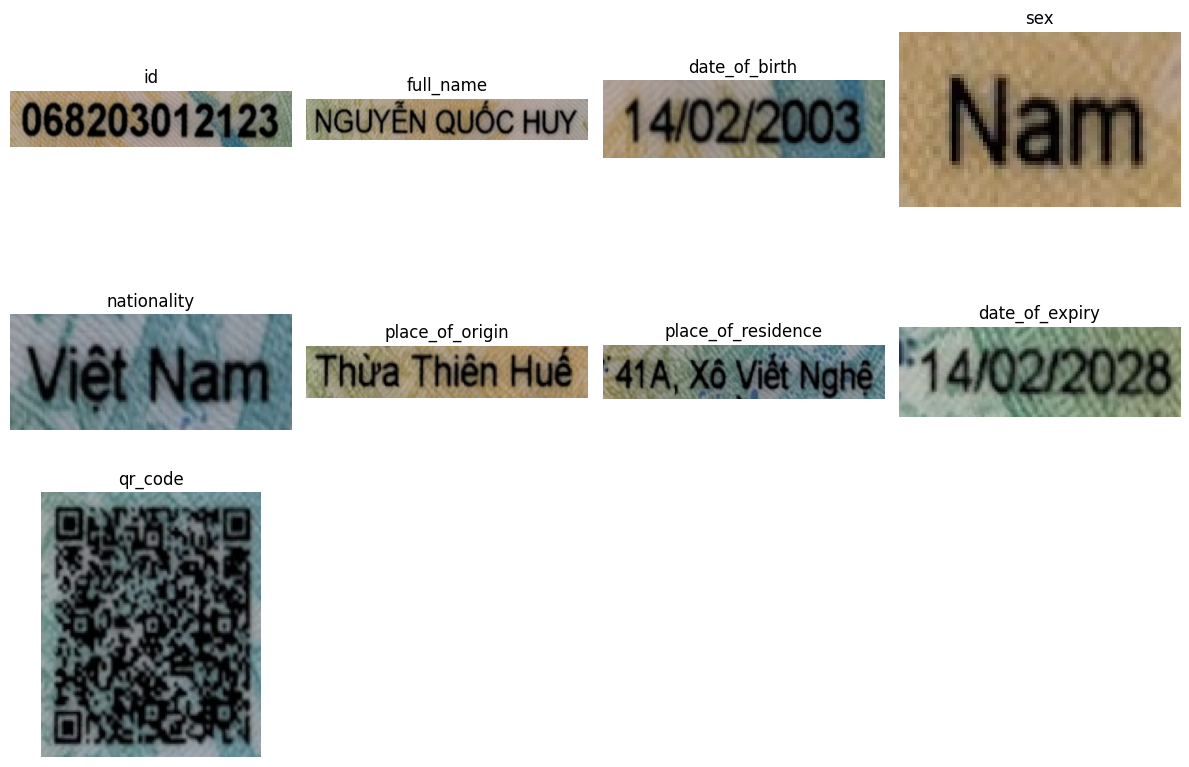

In [250]:
front_cropped_fields = extract_front_field_images(front_field_detector, preprocess_front_img.copy())
plt.figure(figsize=(12, 8))
for idx, crop in enumerate(front_cropped_fields):
    plt.subplot(3, 4, idx + 1)
    print(crop["class_name"])
    plt.imshow(crop['field_img'])
    plt.title(crop["class_name"])
    plt.axis('off')
plt.tight_layout()
plt.show()


fingerprint
issue_place
personal_identification
personal_identification
personal_identification


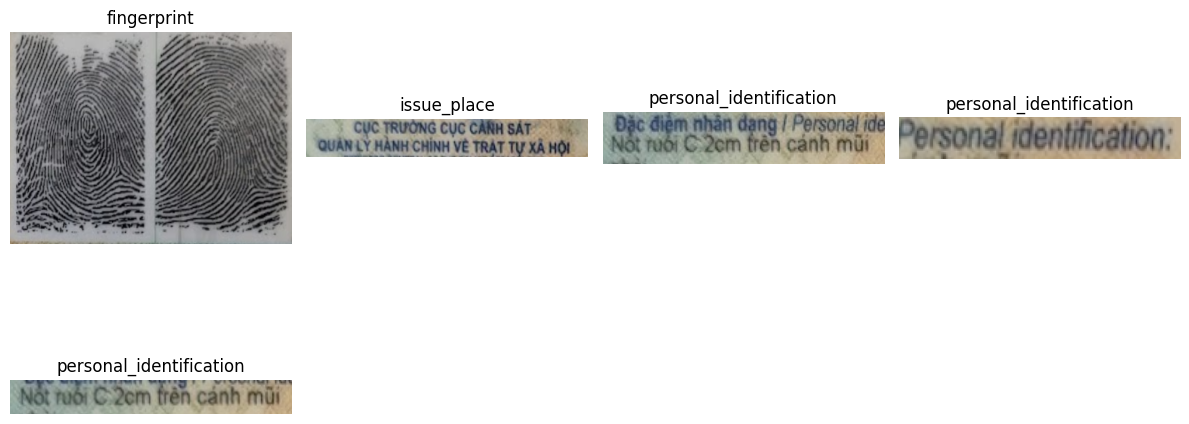

In [247]:
back_cropped_fields = extract_back_field_images(
    back_field_detector, 
    preprocess_back_img.copy(),
    iou_thres=0.6,
    conf_thres=0.6)
plt.figure(figsize=(12, 8))
for idx, crop in enumerate(back_cropped_fields):
    plt.subplot(3, 4, idx + 1)
    print(crop["class_name"])
    plt.imshow(crop['field_img'])
    plt.title(crop["class_name"])
    plt.axis('off')
plt.tight_layout()
plt.show()

## VII. Nhận dạng kí tự

In [262]:
import cv2
import pytesseract
import numpy as np
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
from PIL import Image
import torch
import json

from src.modules.ocr_idcard.utils.issue_place_utils import (
    auto_correct_issue_place,
    ISSUES_PLACES,
)


class IdCardTranslator:
    def __init__(
        self,
        lang="vie",
        tesseract_config=r"--oem 3 --psm 6",
        vietocr_config="vgg_transformer",
        engine="vietocr",
    ):

        self.lang = lang
        self.tesseract_config = tesseract_config
        self.vietocr_config = vietocr_config
        self.engine = engine
        self.vietocr_detector = None
        self.setup_engine()

    def setup_engine(self):
        if self.engine == "vietocr":
            self.vietocr_config = Cfg.load_config_from_name(self.vietocr_config)
            self.vietocr_config["cnn"]["pretrained"] = False
            self.vietocr_config["device"] = (
                "cuda" if torch.cuda.is_available() else "cpu"
            )
            self.vietocr_detector = Predictor(self.vietocr_config)
        else:
            pytesseract.pytesseract.tesseract_cmd = r"/usr/bin/tesseract"

    def read_field(self, img):
        if self.engine == "vietocr":
            return self.vietocr_detector.predict(Image.fromarray(img))
        return pytesseract.image_to_string(
            img, lang=self.lang, config=self.tesseract_config
        )

    def processing_img(
        self,
        img,
        brighten_factor=1.5,
        scale_factor=2.0,
        blur_kernel_size=(3, 3),
        alpha=0.6,
        beta=0.4,
    ):

        if isinstance(img, str):
            img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = self.resize_image(img, scale_factor=scale_factor)

        # brightening
        img = np.clip(img * brighten_factor, 0, 255).astype(np.uint8)
        sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        sharpened = cv2.filter2D(img, -1, sharpen_kernel)
        blured = cv2.GaussianBlur(img, blur_kernel_size, 0)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(img)

        _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Morphology reduce outliers
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

        return cleaned

    def read_front_info(self, crops):
        result = {}
        for idx, crop in enumerate(crops):
            class_name = crop["class_name"]
            if class_name != "qr_code":
                preprocessed_img = self.processing_img(crop["field_img"])
                field_text = self.read_field(preprocessed_img)
                result[class_name] = field_text

        if ("place_of_residence" in result) and ("extend_place_of_residence" in result):
            result["place_of_residence"] += f' {result["extend_place_of_residence"]}'
            result.pop("extend_place_of_residence")

        result["nationality"] = "Việt Nam"
        return result

    def read_back_info(self, crops):
        result = {}
        for idx, crop in enumerate(crops):
            class_name = crop["class_name"]
            if class_name != "fingerprint":
                preprocessed_img = crop["field_img"]
                field_text = self.read_field(preprocessed_img)
                result[class_name] = field_text

        if "issue_place" in result:
            result["issue_place"], score = auto_correct_issue_place(
                result["issue_place"], 0.3
            )
        else:
            result["issue_place"] = ISSUES_PLACES[0]
        return result

    def resize_image(self, image, scale_factor=2.0):
        # Resize the image by scaling
        height, width = image.shape
        new_dim = (int(width * scale_factor), int(height * scale_factor))
        resized_image = cv2.resize(image, new_dim, interpolation=cv2.INTER_CUBIC)
        return resized_image

### 1. Nhận dạng kí tự Tesseract

In [269]:
tesser_translator = IdCardTranslator(
    engine="tesseract",
    tesseract_config="--oem 1 --psm 6"
)

tesser_front_idcard_result = tesser_translator.read_front_info(front_cropped_fields)
print(json.dumps(tesser_front_idcard_result, indent=4, ensure_ascii=False))


tesser_back_idcard_result = tesser_translator.read_back_info(back_cropped_fields)
print(json.dumps(tesser_back_idcard_result, indent=4, ensure_ascii=False))

TesseractNotFoundError: /usr/bin/tesseract is not installed or it's not in your PATH. See README file for more information.

### 2. Nhận dạng kí tự Vietocr

In [263]:
ocr_config = {
    "model": "vietocr",
    "pretrained_cnn_model": "vgg_transformer",
    "device": "cuda"
}
idcard_translator = IdCardTranslator(vietocr_config=ocr_config['pretrained_cnn_model'])

c:\Users\admin\Music\CV_Project\venv\Lib\site-packages\torch\nn\modules\transformer.py:386: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Model weight C:\Users\admin\AppData\Local\Temp\vgg_transformer.pth exsits. Ignore download!


In [ ]:
front_idcard_result = idcard_translator.read_front_info(front_cropped_fields)
print(json.dumps(front_idcard_result, indent=4, ensure_ascii=False))

{
    "id": "068203012123",
    "full_name": "NGUYỄN QUỐC HUY",
    "date_of_birth": "14/02/2003",
    "sex": "Nam",
    "nationality": "Việt Nam",
    "place_of_origin": "Thừa Thiên Huế",
    "place_of_residence": "41Á, Xô Viết Nghệ",
    "date_of_expiry": "14/02/2028"
}


In [265]:
back_idcard_result = idcard_translator.read_back_info(back_cropped_fields)
print(json.dumps(back_idcard_result, indent=4, ensure_ascii=False))

{
    "issue_place": "CỤC TRƯỞNG CỤC CẢNH SÁT QUẢN LÝ HÀNH CHÍNH VỀ TRẬT TỰ XÃ HỘI",
    "personal_identification": "Nốt ruổi C 2cm trên cánh mũi"
}


### 3. So sánh Tesseract và Vietocr

### 4. Kết quả trích xuất Căn cước công dân

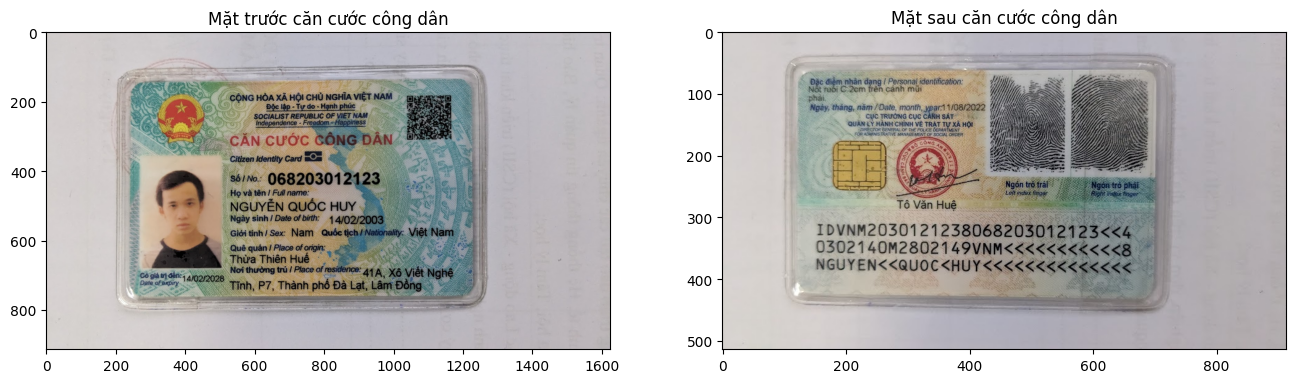

{
    "id": "068203012123",
    "full_name": "NGUYỄN QUỐC HUY",
    "date_of_birth": "14/02/2003",
    "sex": "Nam",
    "nationality": "Việt Nam",
    "place_of_origin": "Thừa Thiên Huế",
    "place_of_residence": "41Á, Xô Viết Nghệ",
    "date_of_expiry": "14/02/2028"
}
{
    "issue_place": "CỤC TRƯỞNG CỤC CẢNH SÁT QUẢN LÝ HÀNH CHÍNH VỀ TRẬT TỰ XÃ HỘI",
    "personal_identification": "Nốt ruổi C 2cm trên cánh mũi"
}


In [267]:
FRONT_IDCARD_PATH = './mattruoc1.jpg'
BACK_IDCARD_PATH = './matsau1.jpg'

front_img = cv2.imread(FRONT_IDCARD_PATH)
back_img = cv2.imread(BACK_IDCARD_PATH)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(front_img[:, :, ::-1])
plt.title("Mặt trước căn cước công dân")

plt.subplot(1, 2, 2)
plt.imshow(back_img[:, :, ::-1])
plt.title("Mặt sau căn cước công dân")
plt.show()

front_idcard_result = idcard_translator.read_front_info(front_cropped_fields)
print(json.dumps(front_idcard_result, indent=4, ensure_ascii=False))

back_idcard_result = idcard_translator.read_back_info(back_cropped_fields)
print(json.dumps(back_idcard_result, indent=4, ensure_ascii=False))

## VIII. Ứng dụng và triển khai thực tế
### 1. Kiến trúc hệ thống
Hệ thống gồm 2 thành phần chính:
<ul>
    <li>Frontend (VueJS)</li>
    <li>Backend (FastAPI)</li>
</ul>

Đường dẫn ứng dụng: <a href="https://ocr.pgonevn.com">https://ocr.pgonevn.com</a></br>
Mã nguồn: <a href="https://github.com/ngquochuydl23/VietnameseIDCard">https://github.com/ngquochuydl23/VietnameseIDCard</a>

### 2. Hình ảnh Demo
#### 2.1 Trang chủ
![image](./screenshots/screenshot_1.png)

#### 2.2 Kết quả
21112801 - Nguyễn Quốc Huy
![image](./screenshots/screenshot_2.png)

21111531 - Lê Thị Thu Hương
![image](./screenshots/screenshot_3.png)

## IX. Kết luận và Hướng phát triển
### 1. Kết luận
- Tổng kết lại
    - Bài toán đã giải quyết được những gì?
    - Các bước xử lý (xác định góc, vùng chữ, OCR).
    - Mô hình sử dụng (YOLOv8, OCR model...).
    - Kết quả đạt được (các chỉ số đánh giá, quan sát trực quan).
- Nhấn mạnh những điểm mạnh của hệ thống.
### 2. Hạn chế
- Mô hình còn nhận diện sai về trường dữ liệu.
- Nhận dạng kí tự tiếng Việt chưa được chính xác.
- Thời gian trích xuất thông tin căn cước công dân chưa nhanh.
### 3. Hướng phát triển
- Cải thiện mô hình:
    - Dùng mô hình mạnh hơn (ví dụ TrOCR thay vì CRNN).
    - Fine-tune thêm với dữ liệu thực tế.

- Tăng chất lượng dữ liệu:

    - Bổ sung ảnh từ môi trường thực tế, đa dạng ngôn ngữ/font/kích thước.

## X. Tài liệu tham khảo

[(https://docs.ultralytics.com/vi/models/yolov8/)](https://docs.ultralytics.com/vi/models/yolov8/)

[(https://miai.vn/2020/07/04/co-ban-ve-object-detection-voi-r-cnn-fast-r-cnn-faster-r-cnn-va-yolo/)](https://miai.vn/2020/07/04/co-ban-ve-object-detection-voi-r-cnn-fast-r-cnn-faster-r-cnn-va-yolo/)

[(https://cmcts.com.vn/vi/nhan-dien-the-cccd-gan-chip.html)](https://cmcts.com.vn/vi/nhan-dien-the-cccd-gan-chip.html)

[(https://github.com/pbcquoc/vietocr)](https://github.com/pbcquoc/vietocr)
